In [1]:
path_to_muograph = "../"
import sys
sys.path.insert(1, path_to_muograph)

![alternative text](../images/muograph_logo.png)


**<h1><center>Hits tutorial</center></h1>**

The `Hits` class is used to **store** and **process muon hits** on detector planes and  to **simulate** basic **detector reasponse**: spatial resolution and efficiency.

**SUMMARY**

1. *Initialization*

    - Accepts **muon hit** and **energy data** either from a `CSV` file or a `Pandas DataFrame`.
    - Supports **unit conversions** for spatial data (e.g., mm, cm, dm, m).
    - Allows **event filtering** based on muon energy.

2. *Detector effects*:

    - Models detector **efficiency** for hit recording and computes a muon detection probability.
    - Models detector **spatial resolution** for hit recording by adding Gaussian noise.

3. *Data*:

    - Stores hits as 3D **tensors** to leverage tensors and **GPU** **acceleration**.
    - Stores **generation level hits** (`gen_hits`) and **reconstructed hits** (after efficiency and spatial resolution simulation `reco_hits`) separatly.

4. *Visualization*:

    - Provides a **plot method** to create 2D histograms of hits on specified detector panels.

The hits are currently red from either a `.csv` file or a `pandas.DataFrame`. Other file format will be supported in the future.


The `Hits` class takes the following arguments:

 - `csv_filename: str` The file path to the CSV containing hit and energy data. Either `csv_filename` or `df` must be provided, but not both.


 - `df (Optional[pd.DataFrame])`: A DataFrame containing hit and energy data. Use this instead of loading data from a CSV file.


#### **IMPORTANT:**

The `.csv` file or `pd.DataFrame` must have spcific column labels, corresponding to the hit coordinate ($x, y, z$) and the label of the plane, e.g `X0` is the muon hit $x$ position on plane $0$. 

Additionally, the muon's energy can be provided.

Below is an example of `.csv` file heading:

In [4]:
csv_file = '../muograph/data/iron_barrel/barrel_and_cubes_scattering.csv'

import pandas as pd
dataframe = pd.read_csv(csv_file)
dataframe.drop(columns=['Unnamed: 0'], inplace=True)
dataframe.columns

Index(['E', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'Y0', 'Y1', 'Y2', 'Y3', 'Y4',
       'Y5', 'Z0', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5'],
      dtype='object')

In [6]:
dataframe.head()

,E,X0,X1,X2,X3,X4,X5,Y0,Y1,Y2,Y3,Y4,Y5,Z0,Z1,Z2,Z3,Z4,Z5
0,777171.00,-531.375,-434.277,-337.1780,-13.5104,83.5915,180.693,163.898,155.160,146.4220,117.29500,108.562,99.828,-99.995,-399.995,-699.995,-1699.99,-1999.99,-2300
1,5544.84,-253.810,-163.143,-72.4511,230.0730,320.9990,411.935,546.567,442.790,339.0000,-7.09602,-111.251,-215.428,-99.995,-399.995,-699.995,-1699.99,-1999.99,-2300
2,105873.00,-275.771,-202.031,-128.2910,117.5990,191.4020,265.205,246.353,190.113,133.8740,-53.57600,-109.790,-166.004,-99.995,-399.995,-699.995,-1699.99,-1999.99,-2300
3,21868.90,261.660,252.103,242.5420,211.9620,203.1980,194.429,-272.845,-182.807,-92.7706,207.05600,296.974,386.899,-99.995,-399.995,-699.995,-1699.99,-1999.99,-2300
4,8097.62,-515.434,-507.150,-498.8580,-471.1510,-462.8350,-454.525,175.703,180.882,186.0590,203.35900,208.555,213.755,-99.995,-399.995,-699.995,-1699.99,-1999.99,-2300


Other arguments are:

 - `plane_labels (Optional[Tuple[int, ...]])`: Specifies the plane labels to include from the data, as a tuple of integers. Only hits from these planes will be loaded if provided.

 - `spatial_res (Optional[Tuple[float, float, float]])`: The spatial resolution of detector panels along the x, y, and z axes, in units specified by `input_unit`. Assumes uniform resolution across all panels if provided.

 - `energy_range (Optional[Tuple[float, float]])`: A tuple specifying the minimum and maximum energy range for hits to be included. Only hits within this range will be processed if provided.

 - `efficiency (float)`: The efficiency factor of the detector panels, applied uniformly across all panels. Defaults to 1.0, representing full efficiency.

 - `input_unit (str)`: The unit of measurement for the input data (e.g., "mm", "cm"). Data will be rescaled to millimeters if another unit is specified. Defaults to "mm".

## **I - Perfect resolution example**

Let's instanciate the `Hits` class, using hits corresponding to the 3 first plane of the detector (panels placed above the volume of interest).

In this example, **no spatial resolution** nor **efficiency** is simulated.

In [7]:
from muograph.hits.hits import Hits

hits_above = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (0, 1, 2),  # Include hits from first planes 0, 1 and 2
    input_unit="mm",  # The distance unit in the csv file.
)

GPU is available. Using NVIDIA GeForce RTX 4090


In [8]:
hits_above

Collection of hits from 137,033 muons on 3 detector panels.

The `Hits` class conveniently stores the hits in a Pytorch `Tensor`, with shape `(3, n_panels, n_mu)`:

In [9]:
hits_above.gen_hits, hits_above.gen_hits.shape

(tensor([[[-531.3750, -253.8100, -275.7710,  ...,  -84.1433,  241.7540,
           -162.8710],
          [-434.2770, -163.1430, -202.0310,  ...,  -88.8023,  226.3680,
           -173.5030],
          [-337.1780,  -72.4511, -128.2910,  ...,  -93.4619,  210.9630,
           -184.0160]],
 
         [[ 163.8980,  546.5670,  246.3530,  ..., -226.8910, -164.3200,
           -520.8990],
          [ 155.1600,  442.7900,  190.1130,  ..., -236.1780, -138.1910,
           -366.8280],
          [ 146.4220,  339.0000,  133.8740,  ..., -245.4630, -112.0880,
           -212.7300]],
 
         [[ -99.9950,  -99.9950,  -99.9950,  ...,  -99.9950,  -99.9950,
            -99.9950],
          [-399.9950, -399.9950, -399.9950,  ..., -399.9950, -399.9950,
           -399.9950],
          [-699.9950, -699.9950, -699.9950,  ..., -699.9950, -699.9950,
           -699.9950]]], device='cuda:0'),
 torch.Size([3, 3, 137033]))

In [10]:
event = 120
plane_label = 0

(
    f"Muon #{event} hits detector panel {plane_label} "
    f"at x, y, z = {hits_above.gen_hits[0, plane_label, event]:.1f},"
    f" {hits_above.gen_hits[1, plane_label, event]:.1f},"
    f" {hits_above.gen_hits[2, plane_label, event]:.1f} mm "
)


'Muon #120 hits detector panel 0 at x, y, z = -478.2, 372.3, -100.0 mm '

Muon hits can be plotted on a 2D histogram, using the `plot` method:

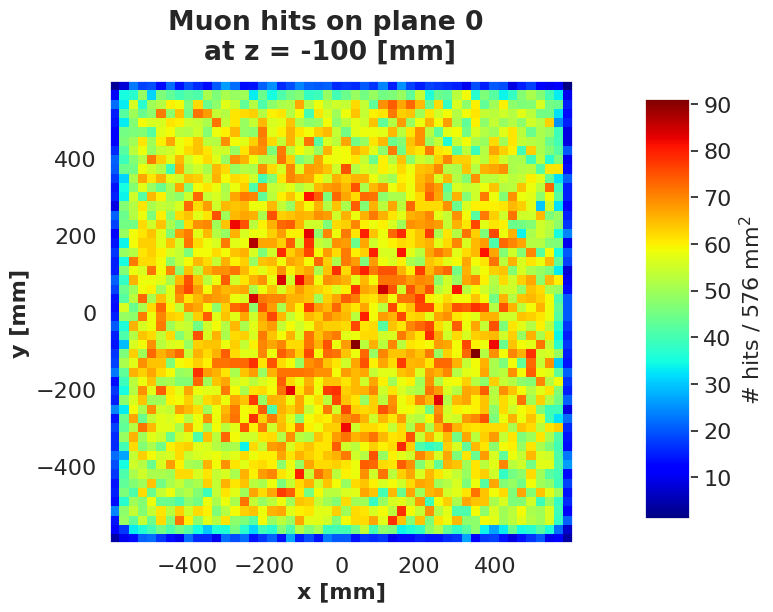

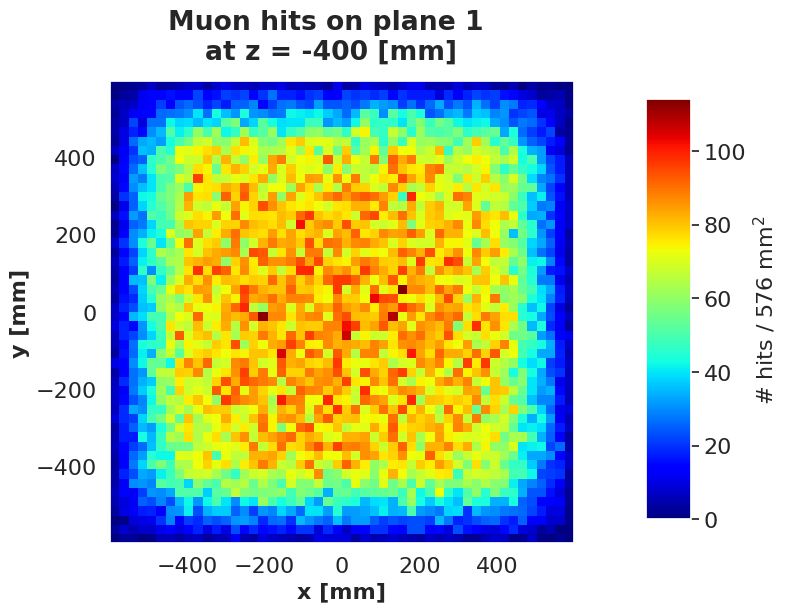

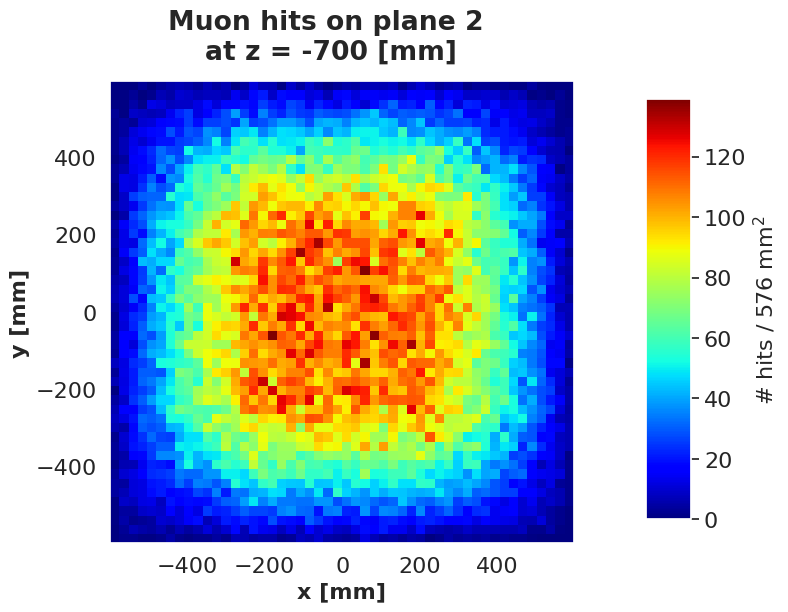

In [12]:
hits_above.plot(plane_label = 0)
hits_above.plot(plane_label = 1)
hits_above.plot(plane_label = 2)

Because no spatial resolution value was used as argument, the generation level hits `gen_hits` and reconstructed hits `reco_hits` are identical:

In [13]:
diff = (hits_above.gen_hits - hits_above.reco_hits).unique()
diff

tensor([0.], device='cuda:0')

## **II - 1mm spatial resolution example**

Now let's **simulate** a **1 mm spatial resolution** along the horizontal direction ($x, y$ axis), by providing a `spatial_res` argument.

Assuming horizontal planes, we choose a spatial resolution of 1 mm along the $x$ and $y$ axis. The vertical coordinate $z$ is left unchanged.

In [14]:
hits_1mm = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (0, 1, 2),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
    spatial_res = (1.0, 1.0, 0.)  # The spatial resolution along x, y and z in mm.
)

The **reconstructed hits** `reco-hits` are computed by adding **Gaussian noise** to the true hits `gen_hits`:

$$
xyz_{\mathrm{reco}} = xyz_{\mathrm{gen}} + \mathcal{G}(\mu=0, \sigma = \sigma_{xyz}) 
$$

with $\mathcal{G}$ a Guassian distribution with mean $\mu = 0$ and standard deviation $\sigma$.

The **spatial resolution** is assumed to be **uniform** across the whole panel's area.

In [15]:
# Copmute the difference between true and reconstructed hits
diff = (hits_1mm.gen_hits - hits_1mm.reco_hits)
diff_x, diff_y, diff_z = diff[0].ravel(), diff[1].ravel(), diff[2].ravel()

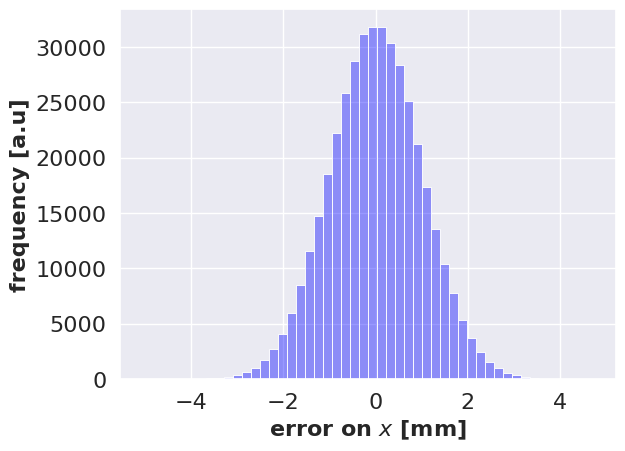

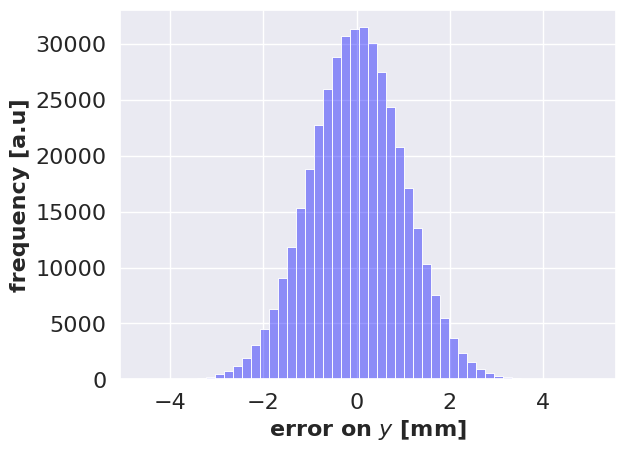

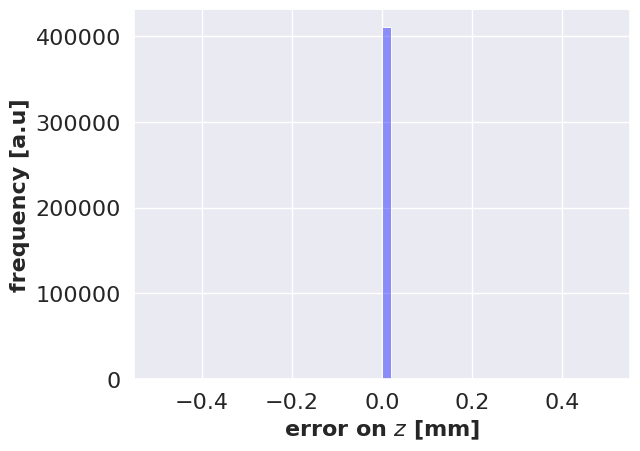

In [16]:
from muograph.plotting.plotting import plot_hist
plot_hist(diff_x, xlabel=r"error on $x$ [mm]")
plot_hist(diff_y, xlabel=r"error on $y$ [mm]")
plot_hist(diff_z, xlabel=r"error on $z$ [mm]")


The **effect** of **spatial resolution** on the reconstructed **tracks** will be treated in **tutorial 2**: `02_Tracking.ipynb`.

## **III - 90% efficiency example**

Now let's **simulate** a 90% individual panel **efficiency** by providing an efficiency argument.

In [17]:
hits_90eff = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (0, 1, 2),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
    efficiency = 0.90,  # The individual panel detection efficiency 
    )

The **efficiency** is defined as the **probability** for a **hit** to be **recorded** by a detector panel.

Based on the efficiency value, each hit receives either 1 (hit detected) or 0 (no detection) as a `hits_eff` variable.

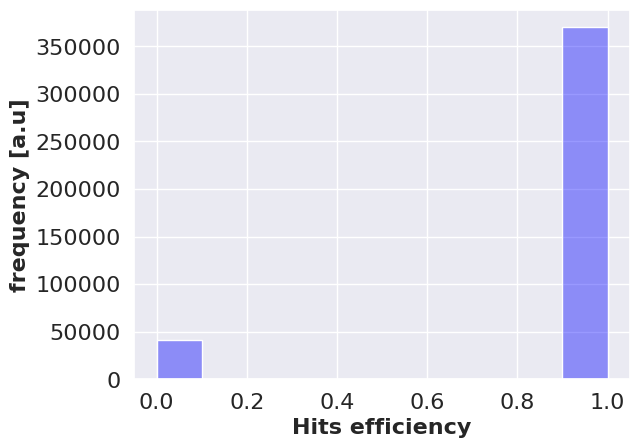

# detected hits = 370099
# rejected hits = 41000
effective efficiency = 90.03


In [19]:
from muograph.plotting.plotting import plot_hist
plot_hist(hits_90eff.hits_eff.ravel(), xlabel="Hits efficiency", n_bins=10)

n_hits = (hits_90eff.n_mu * hits_90eff.n_panels)
n_detected_hits = hits_90eff.hits_eff.sum().detach().cpu().item()
n_rejected_hits =  n_hits - n_detected_hits

print(f"# detected hits = {n_detected_hits}")
print(f"# rejected hits = {n_rejected_hits}")
print(f"effective efficiency = {(n_detected_hits / n_hits) * 100 :.2f}")


The effect of efficiency on the reconstructed tracks will be treated in tutorial 3: `03_Tracking_muon_scattering_tomography.ipynb`.